# Assignment 1 - CS7.505 - Computer Vision

**Name**: Avneesh Mishra <br>
**Roll No.**: 2021701032

Assignment 1 submission

In [172]:
# Import everything
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation
import glob
import copy

---

## DLT - Direct Linear Transform

The direct linear transform is a method that can be used to calibrate a camera using 3D $\leftrightarrow$ 2D correspondences (using a single image).



**References**

-  Cyrill Stachniss videos on YouTube
    - [Direct Linear Transform - 5 Minutes with Cyrill](https://youtu.be/Fdwa0UEJ_F8)
    - [Direct Linear Transform for Camera Calibration and Localization](https://youtu.be/3NcQbZu6xt8)


### Theory

The proof and derivation of the DLT (Direct Linear Transform) algorithm

Say we have an image, and we know the world coordinates of some key points in the image. Let this correspondence map be given by $\mathbf{x}_i \leftrightarrow \mathbf{X}_i$. From the pinhole camera model, we have the following relation

$$
\mathbf{x}_i = \mathbf{K} \, ^{C}_{W}\mathbf{R} \left [ \mathbf{I} \mid  - \, _{W}\mathbf{X}_C \right ] \; \mathbf{X}_i
\Rightarrow
\mathbf{x}_i = \mathbf{P} \, \mathbf{X}_i
$$

Where
- $\mathbf{x}_i$ is the homogenized pixel coordinates (a $3, 1$ vector). We can express this as

    $$
    \mathbf{x}_i = \begin{bmatrix}
        u_i & v_i & w_i
        \end{bmatrix} \equiv \begin{bmatrix}
        x_i & y_i & 1
        \end{bmatrix}
    $$

- $\mathbf{K}$ is the camera **intrinsic** matrix, composed of focal lengths $f_x$, $f_y$ (along X and Y), skew parameter $s$, and camera image center $c_x$, $c_y$. These five intrinsic parameters transform a 3D point in world coordinates into image coordinates. This matrix is written as

    $$
    \mathbf{K} = \begin{bmatrix}
        f_x & s & -c_x \\
        0 & f_y & -c_y \\
        0 & 0 & 1
        \end{bmatrix}
    $$
- $^{C}_{W}\mathbf{R}$ is the rotation matrix ($3,3$ direction cosines) that expresses the _world_ frame in the _camera_ frame. This is to express the orientation of the world frame in the camera frame, thereby transforming a vector (ray) from world frame representation to the camera frame representation.
- $_{W}\mathbf{X}_C$ is the origin of the camera expressed in the world coordinates. This, together with $^{C}_{W}\mathbf{R}$ form the **extrinsic** parameters. There are three translational and three rotational parameters (totally 6 extrinsic parameters).
- $\mathbf{P} = \mathbf{K} \, ^{C}_{W}\mathbf{R} \left [ \mathbf{I} \mid  - \, _{W}\mathbf{X}_C \right ]$ is the short-hand representation of the camera projection matrix. Its shape is a $3, 4$ matrix.
- $\mathbf{X}_i$ is the homogenized world coordinates (a $4, 1$ vector). We can express this as

    $$
    \mathbf{X}_i = \begin{bmatrix}
        X_i & Y_i & Z_i & 1
        \end{bmatrix}
    $$


The set of correspondences can be condensed into a system of linear equations (with some constraints), represented as $\mathbf{Ap} = 0$. Where $\mathbf{A}$ is a matrix of shape $(2n, 12)$ (where we have $n$ correspondences), and $\mathbf{p}$ is a $(12, 1)$ vector which is formed by vertically stacking the rows of $\mathbf{P}$. This is derived as follows

$$
\begin{bmatrix}
u_i \\ v_i \\ w_i
\end{bmatrix} = \begin{bmatrix}
p_{11} & p_{12} & p_{13} & p_{14} \\
p_{21} & p_{22} & p_{23} & p_{24} \\
p_{31} & p_{32} & p_{33} & p_{34}
\end{bmatrix} \begin{bmatrix}
X_i \\ Y_i \\ Z_i \\ 1
\end{bmatrix}
\Rightarrow \begin{bmatrix}
u_i \\ v_i \\ w_i
\end{bmatrix} = \begin{bmatrix}
p_{11} X_i + p_{12} Y_i + p_{13} Z_i + p_{14} \\
p_{21} X_i + p_{22} Y_i + p_{23} Z_i + p_{24} \\
p_{31} X_i + p_{32} Y_i + p_{33} Z_i + p_{34}
\end{bmatrix}
$$

$$
x_i = \frac{u_i}{w_i} = \frac{p_{11} X_i + p_{12} Y_i + p_{13} Z_i + p_{14}}{p_{31} X_i + p_{32} Y_i + p_{33} Z_i + p_{34}} \Rightarrow p_{11} X_i + p_{12} Y_i + p_{13} Z_i + p_{14} - x_i \left ( p_{31} X_i + p_{32} Y_i + p_{33} Z_i + p_{34} \right ) = 0 \\
\Rightarrow \begin{bmatrix}
X_i & Y_i & Z_i & 1 & 0 & 0 & 0 & 0 & -x_i X_i & -x_i Y_i & -x_i Z_i & -x_i
\end{bmatrix} \mathbf{p} = 0 \rightarrow \mathbf{a}_{ix} \mathbf{p} = 0
$$

$$
y_i = \frac{v_i}{w_i} = \frac{p_{21} X_i + p_{22} Y_i + p_{23} Z_i + p_{24}}{p_{31} X_i + p_{32} Y_i + p_{33} Z_i + p_{34}} \Rightarrow p_{21} X_i + p_{22} Y_i + p_{23} Z_i + p_{24} - y_i \left ( p_{31} X_i + p_{32} Y_i + p_{33} Z_i + p_{34} \right ) = 0 \\
\Rightarrow \begin{bmatrix}
0 & 0 & 0 & 0 & X_i & Y_i & Z_i & 1 & -y_i X_i & -y_i Y_i & -y_i Z_i & -y_i
\end{bmatrix} \mathbf{p} = 0 \rightarrow \mathbf{a}_{iy} \mathbf{p} = 0
$$

Concatenating such correspondences (vertically stacking the above two equations), we get

$$
\begin{bmatrix}
\mathbf{a}_{0x}^\top \\ \mathbf{a}_{0y}^\top \\
\vdots \\ \mathbf{a}_{ix}^\top \\ \mathbf{a}_{iy}^\top \\ \vdots \\
\mathbf{a}_{nx}^\top \\ \mathbf{a}_{ny}^\top
\end{bmatrix}_{(2n, 12)} \begin{bmatrix}
\mathbf{p}_{1,:} \\ \mathbf{p}_{2,:} \\ \mathbf{p}_{3,:}
\end{bmatrix}_{(12, 1)} = \mathbf{0}_{(2n, 1)}
\rightarrow \mathbf{A} \mathbf{p} = \mathbf{0}
$$

Given that we have $\mathbf{A}$ through correspondences, we need to find $\mathbf{p}$. Obviously, the trivial solution of $\mathbf{p} = \mathbf{0}$ is to be avoided. There are several methods of doing this. Note that to get a solution $n \ge 6$ (as there are 12 variables and each correspondence gives us 2 equations).

#### SVD method for DLT



Applying Singular Value Decomposition to $\mathbf{A}$, we can rewrite it as $\mathbf{A}_{(2n, 12)} = \mathbf{U}_{(2n, 2n)} \mathbf{D}_{(2n, 12)} \mathbf{V}^\top_{(12, 12)}$. We may also cases where $\mathbf{Ap} \approx \mathbf{0}$, say when there are multiple points or there is noise in the observations. In such cases, the optimization objective becomes to minimize the norm (such that $\mathbf{p} \neq \mathbf{0}$). This is written as

$$
\mathbf{p} = \underset{\mathbf{p}}{\textup{argmin}} \left \| \mathbf{Ap} \right \| \ni \mathbf{p} \ne \mathbf{0}
$$

We can apply the following chain of transformations to the minimization objective

$$
\textup{min} \| \mathbf{A p} \| = \textup{min} \| \mathbf{UDV^\top p} \| = \textup{min} \| \mathbf{DV^\top p} \| = \textup{min} \| \mathbf{Dy} \|
$$

Where $\mathbf{y} = \mathbf{V^\top p}$ (we need $\mathbf{y} \neq \mathbf{0}$). Note that $\mathbf{U}$ and $\mathbf{V}$ are orthogonal matrices (their determinant is $1$ and their inverse is their transpose), and $\mathbf{D}$ is a diagonal matrix (non-square) consisting of singular values (in descending order). The value of $\mathbf{y}$ which minimizes the objective above is $\mathbf{y}_{(12, 1)} = \begin{bmatrix} 0 & 0 & \cdots & 0 & 1 \end{bmatrix}^\top$. Note that $\mathbf{p}$ is also homogeneous, so any value other than $1$ would mean the same thing ($\mathbf{P}$ is a homogeneous matrix).

We can further simplify $\mathbf{y} = \mathbf{V^\top p} \Rightarrow \mathbf{p} = \mathbf{V y}$. Substituting for $\mathbf{y}$, we get $\mathbf{p}$ as the last column of $\mathbf{V}$. That is, $\mathbf{p} = \mathbf{V}_{(:, 12)}$ should be a viable solution.


#### Decomposition of P

Now that $\mathbf{P}$ is known, get the intrinsic parameters (matrix $\mathbf{K}$) and the extrinsic parameters (matrix $\left [ \mathbf{R} | \mathbf{t} \right ]$).


##### QR Decomposition method

We can write the camera projection matrix as

$$ \mathbf{P} = \mathbf{K R} \left [ \mathbf{I} \mid -\mathbf{X}_O \right ] = \left [ \mathbf{K R} \mid -\mathbf{K R} \, \mathbf{X}_O \right ] $$

Assuming $\mathbf{H} = \mathbf{K R}$ and $\mathbf{h} = - \mathbf{K R} \, \mathbf{X}_O = -\mathbf{H} \, \mathbf{X}_O$, we can readjust the above equations as

$$ \mathbf{P} = \left [ \mathbf{H \mid h} \right ] $$

From this, it is clear that $\mathbf{X}_O = -\mathbf{H}^{-1} \mathbf{h}$. Now, we only need to find $\mathbf{R}$ (rotation matrix) and $\mathbf{K}$ (the camera calibration matrix). Let's see the inverse of $\mathbf{H}$

$$ \mathbf{H}^{-1} = \left( \mathbf{KR} \right )^{-1} = \mathbf{R}^{-1} \, \mathbf{K}^{-1} = \mathbf{R}^\top \, \mathbf{K}^{-1} $$

Performing the [QR decomposition](https://en.wikipedia.org/wiki/QR_decomposition) of $\mathbf{H}^{-1}$ (this can be done using [numpy.linalg.qr](https://numpy.org/doc/stable/reference/generated/numpy.linalg.qr.html) in numpy), we can decompose it into $\mathbf{H}^{-1} = QR$ (here, $Q$ is an orthogonal matrix and $R$ is an upper / right triangular matrix). We now finally have $Q \equiv \mathbf{R}^\top$ and $R \equiv \mathbf{K}^{-1}$. This gives us

$$ \mathbf{R} = Q^\top \quad \textup{and} \quad \mathbf{K} = R^{-1} $$

Note that because of the camera image coordinates, the screen placement has been emulated to be in the front of the camera. This will require adjustment (as it has to be behind the principle / pole of the camera). A simple 180 degree rotation to $\mathbf{R}$ about the Z axis of the world (vertically up) should work (this is transform w.r.t. a fixed frame, so pre-multiply it). The same adjustment will then also be needed for $\mathbf{K}$, but, to maintain the $\mathbf{H} = \mathbf{KR}$ relation, the adjustment to K will be a pose-multiplication. Also, K has to be homogenized (the last element has to be scaled to 1). This means, the last step for rectification is as follows

$$ \mathbf{R} \leftarrow \textup{Rot}(\mathbf{Z}, \pi) \times \mathbf{R} \quad \textup{and} \quad \mathbf{K} \leftarrow \frac{\mathbf{K} \times \textup{Rot}(\mathbf{Z}, \pi)}{K_{3,3}} $$

Where $\textup{Rot}(\mathbf{Z}, \pi) = \textup{diag}(-1, -1, 1)$ and $K_{3,3}$ is the last row's last column element of $\mathbf{K}$. With this rectification, the intrinsic and extrinsic parameters have been obtained. Note that there must be a negative focal length in Y direction (image is vertically inverted in the pinhole model).

### Implementation

The functional implementations of the DLT method

#### SVD Implementation

SVD method described above (in theory)

In [140]:
def DLT_SVD_estimateP(wpts: np.ndarray, ipts: np.ndarray):
    """
        Calculates the camera projection matrix P, such that x = P * X
        where X is 4, 1 (homogenized world point) and x is 3, 1
        (homogenized image point). P is a (3, 4) matrix. Uses the DLT
        method (SVD technique). At least 6 points (all shouldn't be on
        the same plane) are needed.

        Parameters:
        - wpts: np.ndarray  shape: N, 3
            The points in the world coordinate (non-homogenized)
        - ipts: np.ndarray  shape: N, 2
            Non-homogenized point correspondences of the world points
            in the image. Image pixel coordinates.
        
        Returns:
        - P: np.ndarray     shape: 3, 4
            The camera projection matrix. The norm of the flattened
            matrix (vector) is 1.
    """
    # Number of correspondences
    N = wpts.shape[0]
    # Homogenized correspondences
    X = np.hstack((wpts, np.ones((N, 1))))
    x = np.hstack((ipts, np.ones((N, 1))))
    # Homogenized equations for i: a_i * p = 0 (per correspondence)
    a_i = lambda i: np.vstack((
        np.hstack((-X[i], np.zeros(4), x[i][0]*X[i])),
        np.hstack((np.zeros(4), -X[i], x[i][1]*X[i]))
    ))
    # Stacked into the homogeneous matrix
    A = np.vstack([a_i(i) for i in range(N)])
    # SVD of A
    U, D, Vh = np.linalg.svd(A)
    # Last column of V
    p = Vh.T[:, -1]
    # Reshape vector to matrix
    P = p.reshape(3, 4)
    return P

#### Decomposition of P into R, K, X_o

Given the camera projection matrix, get the $\mathbf{R}$ (rotation matrix expressing world in camera frame), $\mathbf{K}$ (the camera intrinsic matrix that projects a ray in camera frame to a pixel), $\mathbf{X}_{O}$ (origin of camera in world frame). The matrix $\mathbf{P}$ is given by

$$ \mathbf{P} = \mathbf{K R} [ \mathbf{I} \mid -\mathbf{X}_O ] $$

The decomposition using QR decomposition is discussed above (in theory)

In [141]:
def ret_RKT_qr(P):
    """
        Uses QR decomposition to decompose a camera projection matrix
        into R, K, and X_O.

        Parameters:
        - P: np.ndarray     shape: (4, 4)
            Camera projection matrix
        
        Returns:
        - R: np.ndarray     shape: (3, 3)
            Rotation matrix (direction cosines) expressing world in
            camera frame
        - K: np.ndarray     shape: (3, 3)
            Camera projection matrix (made by intrinsics) that 
            projects a ray in camera frame to the image coordinates
            (homogeneous)
        - X_O: np.ndarray       shape: (3, 1)
            The camera origin in the world frame
    """
    # Decompose into H matrix and h vector
    H = P[0:3, 0:3]
    h = P[0:3, 3]
    # Retrieve X_O
    X_O = -np.linalg.inv(H) @ h
    # Invert H
    H_inv = np.linalg.inv(H)
    # QR Decomposition to H_inv
    q, r = np.linalg.qr(H_inv)
    rot_z_pi = np.diag([-1, -1, 1])
    # R calculation
    R = q.T
    R = rot_z_pi @ R
    # K calculation
    K = np.linalg.inv(r)
    K = K @ rot_z_pi / K[2,2]
    return R, K, X_O

In [142]:
# Some rough space, ignore this cell

### RANSAC based DLT

Random Sample Consensus is a method to find the best fitting model among many points, using outlier rejection (or maximum inlier sampling).

**References**

- Cyrill Stachniss videos on YouTube
    - [RANSAC - 5 Minutes with Cyrill](https://youtu.be/9D5rrtCC_E0)
    - [RANSAC - Random Sample Consensus](https://youtu.be/Cu1f6vpEilg)


In [143]:
def RANSAC_DLT_sampling(w_pts: np.ndarray, i_pts: np.ndarray,
    err_thresh: int, p=0.95, e=0.25):
    """
        Estimating the best camera projection matrix P using RANSAC
        (maximum inliers).

        Parameters:
        - w_pts: np.ndarray     shape: N, 3
            The points in the world coordinate (non-homogenized)
        - i_pts: np.ndarray     shape: N, 2
            Non-homogenized point correspondences of the world points
            in the image. Image pixel coordinates.
        - err_thresh: int
            The error threshold for a pixel to be considedreed an 
            inlier. This is the absolute deviation of reprojection (in
            pixels).
        
        Returns:
        - best_P: np.ndarray        shape: (3, 4)
            The best camera projection matrix (maximum inliers)
        - ncpts: np.ndarray         shape: (T, 1)
            Number of inliers for each of the 'T' trials of resampling
        - P_vals: list[np.ndarray]      len: T
            The camera projection matrix for each of the trials. Shape
            of each element is (3, 4)
    """
    # Parameters for RANSAC algorithm
    s = 6       # Number of points (6 points)
    T = int(np.ceil(np.log(1 - p)/np.log(1-(1-e)**s)))
    N, _ = w_pts.shape
    # Homogeneous
    X_h = np.vstack((w_pts.T, np.ones((1, N))))
    x_h = np.vstack((i_pts.T, np.ones((1, N))))
    # Random sampling
    ncpts = []  # Number of conforming points
    P_vals = [] # Values of the 'P' matrix
    for i in range(T):
        # Randomly sample columns
        j = np.random.choice(N, s, replace=False)
        # Sampled points
        w_h = X_h[:, j] # World points
        i_h = x_h[:, j] # Image points
        # Calculate P
        P = DLT_SVD_estimateP(w_h.T[:,:3], i_h.T[:,:2])
        # Project 3D point to pixel
        x_h_ = P @ X_h
        x_h_ = x_h_/x_h_[2] # Unit scale (to real pixel values)
        disp_vect = np.linalg.norm(x_h_ - x_h, axis=0)
        num_in = np.sum(disp_vect < err_thresh) # No. of inliers
        # Log this run
        ncpts.append(num_in)
        P_vals.append(P)
    # Sanitize
    ncpts = np.array(ncpts)
    # Best conforming values
    best_P = P_vals[np.argmin(ncpts)]
    return best_P, ncpts, P_vals

In [144]:
# A rough work cell to experiment! Ignore this

### Real-world experiment

Using the given black dots pattern and real-world measurements to do the DLT & RANSAC calibration

In [145]:
# A function that takes an image and returns the marked indices
def get_clicked_points(img, img_winname = "Point Picker", 
    dmesg = False):
    """
        Get the clicked locations as a list of [x, y] points on image
        given as 'img'. Note that the origin is at the top left corner
        with X to the right and Y downwards.

        Parameters:
        - img: np.ndarray   shape: N, M, C
            An image, should be handled by OpenCV or be a numpy array
            (height, width, channels). The passed image is not altered
            by the function.
        - img_winname: str  default: "Point Picker"        
            Window name (to be used by OpenCV)
        - dmesg: bool or str    default: False
            If True (or `str` type) a string for debug is printed. If
            the type is `str`, then the string is prepended to the
            debug message.

        Returns:
        - img_points: list
            A list of [x, y] points clicked on the image
        - _img: np.ndarray  shape: N, M, C
            The same image, but annotated with points clicked. Random
            colors are assigned to each point.
    """
    img_points = [] # A list of [x, y] points (clicked points)
    _img: np.ndarray = img.copy()   # Don't alter img
    # Main event handler
    def img_win_event(event, x, y, flags, params):
        if event == cv.EVENT_LBUTTONUP:
            # Print the debug message (if True or 'str')
            if dmesg == True or type(dmesg) == str:
                db_msg = f"Clicked on point (x, y): {x}, {y}"
                if type(dmesg) == str:
                    db_msg = dmesg + db_msg
                print(db_msg)
            # Record point
            img_points.append([x, y])   # Record observation
            # -- Put marker on _img for the point --
            # Random OpenCV BGR color as tuple
            _col = tuple(map(int, np.random.randint(0, 255, 3)))
            # Add circle
            cv.circle(_img, (x, y), 30, _col, -1)
            # Add text
            cv.putText(_img, f"{len(img_points)}", (x, y-60),
                cv.FONT_HERSHEY_SIMPLEX, 5, _col, 10, cv.LINE_AA)
    # Create GUI Window
    cv.namedWindow(img_winname, cv.WINDOW_NORMAL)
    cv.resizeWindow(img_winname, 800, 500)  # Window (width, height)
    cv.setMouseCallback(img_winname, img_win_event)
    # Main loop
    while True:
        cv.imshow(img_winname, _img)
        k = cv.waitKey(1)
        if k == ord('q'):
            break
    cv.destroyWindow(img_winname)
    # Return results
    return img_points, _img


In [146]:
# Image file
img_filename = "./../data/black-dots.JPG"   # Dots pattern
# Read image
img1 = cv.imread(img_filename)

In [147]:
pts, img_tmp = get_clicked_points(img1, "Click Points", "\t")
# cv.imwrite("./tmp_img.jpg", img_tmp)

	Clicked on point (x, y): 2750, 1802
	Clicked on point (x, y): 3735, 905


The points clicked were as follows

<img src="./../images/clicked_pts.jpg" width=500 />

The world points are chosen through the following left-handed coordinate system

<img src="./../data/measurements.JPG" width=500 />

In [148]:
clicked_pts_img = np.array(pts, float)
clicked_pts_world_mm = np.array([
    [6, 1, 0],  # 1
    [5, 0, 1],  # 2
    [6, 2, 0],  # 3
    [5, 0, 2],  # 4
    [4, 2, 0],  # 5
    [3, 0, 2],  # 6
    [2, 2, 0],  # 7
    [1, 1, 0],  # 8
    [0, 0, 1],  # 9
    [1, 0, 3],  # 10
    [2, 0, 1],  # 11
    [3, 2, 0],  # 12
    [3, 0, 3],  # 13
    [4, 0, 3],  # 14
    [4, 0, 1],  # 15
    [5, 1, 0],  # 16
    [0, 2, 0],  # 17
    [4, 1, 0],  # 18
    [4, 0, 4],  # 19
    [5, 2, 0],  # 20
], float) * 36.0

In [149]:
# Save the data
fname = "./clicked_corres.npz"
# np.savez(fname, img_pts=clicked_pts_img, 
#     world_pts=clicked_pts_world_mm)   # Uncomment to save!
# Load data
data = np.load(fname)   # Restore from backup
clicked_pts_img : np.ndarray = data["img_pts"]
clicked_pts_world_mm : np.ndarray = data["world_pts"]

#### DLT using 6 points

Using 6 randomly picked point correspondences and performing DLT

In [150]:
# 6 random correspondences
N, _ = clicked_pts_img.shape
i = np.random.choice(N, 6, replace=False)
X_pts = clicked_pts_world_mm[i]
x_pts = clicked_pts_img[i]
# Get the P estimate
P = DLT_SVD_estimateP(X_pts, x_pts)
R, K, X_o = ret_RKT_qr(P)   # Decompose P
# Reconstruct it
P_re = K @ R @ np.hstack((np.eye(3), -X_o.reshape(3, 1)))
if np.allclose(P/P[2, 3], P_re/P_re[2, 3]):
    print("Reconstruction verified")

Reconstruction verified


In [151]:
# Save and restore
fname = "./P_dlt6.npy"
# np.save(fname, P)
P_re = np.load(fname)   # Load from backup
R, K, X_o = ret_RKT_qr(P_re)   # Decompose P_re
print(f"K = {K}\nR = {R}\nX_o (in mm) = {X_o}")

K = [[ 1.14435870e+04 -1.45268656e+02  2.94389684e+03]
 [ 0.00000000e+00  1.13649656e+04  2.98418918e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
R = [[ 0.97926615 -0.01956558  0.20163083]
 [ 0.10409094  0.90247877 -0.41796788]
 [-0.17378976  0.43028974  0.88580351]]
X_o (in mm) = [-14.20258944 186.88010503 487.82754046]


Reproject and get the error estimate. This is simply the number of pixels the reprojection was off by (on the entire set of $N$ points)

In [152]:
# Get reprojected points
x_im = P_re @ np.hstack((clicked_pts_world_mm, np.ones((N, 1)))).T
x_im = x_im/x_im[2]
# Error vector
err = x_im - np.vstack((clicked_pts_img.T, np.ones((1, N))))
deviation = np.linalg.norm(err, axis=0) # Pixel deviation per point
td = np.sum(deviation)  # Total deviation
print(f"Total deviation of {td:.3f} pixels")

Total deviation of 250.006 pixels


#### DLT using RANSAC

The actual RANSAC based DLT

In [153]:
P_best, ncpts, p_vals = RANSAC_DLT_sampling(clicked_pts_world_mm,
    clicked_pts_img, 5, 0.99, 0.30)
P_best = p_vals[np.argmax(ncpts)]
# Decompose the best P value
R, K, X_o = ret_RKT_qr(P_best)
# Reconstruct P
P_re = K @ R @ np.hstack((np.eye(3), -X_o.reshape(3, 1)))
if np.allclose(P_best/P_best[2, 3], P_re/P_re[2, 3]):
    print("Reconstruction verified")

Reconstruction verified


In [154]:
# Save and restore
fname = "./P_dlt_ransac.npy"
# np.save(fname, P_best)
P_re = np.load(fname)   # Load from backup
R, K, X_o = ret_RKT_qr(P_re)   # Decompose P_re
print(f"K = {K}\nR = {R}\nX_o (in mm) = {X_o}")

K = [[ 1.20833304e+04 -9.08113208e+01  2.98478171e+03]
 [ 0.00000000e+00  1.19868598e+04  2.91148195e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
R = [[ 0.97683187 -0.00681329  0.2138997 ]
 [ 0.09451178  0.91047812 -0.40261285]
 [-0.19200788  0.41350111  0.89002798]]
X_o (in mm) = [-28.11651383 190.52047061 508.10116936]


Testing the above results, same way as the DLT using 6 points.

In [155]:
# Get reprojected points
x_im = P_re @ np.hstack((clicked_pts_world_mm, np.ones((N, 1)))).T
x_im = x_im/x_im[2]
# Error vector
err = x_im - np.vstack((clicked_pts_img.T, np.ones((1, N))))
deviation = np.linalg.norm(err, axis=0) # Pixel deviation per point
td = np.sum(deviation)  # Total deviation
print(f"Total deviation of {td:.3f} pixels")

Total deviation of 187.219 pixels


As observed, the RANSAC method results in a smaller _overall_ deviation. RANSAC method has a deviation of 187 pixels and normal (randomly selected 6-point method) DLT has a deviation of 250 pixels. Note that these values are distributed over _20 points_. Note that the best camera projection could be decomposed as

```txt
K = [[ 1.20833304e+04 -9.08113208e+01  2.98478171e+03]
 [ 0.00000000e+00  1.19868598e+04  2.91148195e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
R = [[ 0.97683187 -0.00681329  0.2138997 ]
 [ 0.09451178  0.91047812 -0.40261285]
 [-0.19200788  0.41350111  0.89002798]]
X_o (in mm) = [-28.11651383 190.52047061 508.10116936]
```

The `X_o` part specially makes sense (note that it is mentioned in millimeters). Even through we used a left-hand coordinate system (cross product uses left hand, not right hand), we got fairly decent estimates of the camera pose in the world.

---

## Distortion & Wireframe

Correcting the barrel (outwards) or pincushion (inwards) lens distortion, and viewing the wireframes

### Distortion

The barrel or pincushion distortion on the images

#### Example: Checkerboard

The complete un-distortion process is shown for the following checkerboard image

<img src="./../data/left04.jpg" width=300>

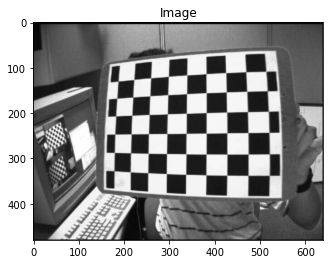

In [156]:
fname = "./../data/left04.jpg"
img = cv.imread(fname)
plt.title("Image")
plt.imshow(img)
plt.show()

Step 1: Set up variables

The variable descriptions are as follows

- `chb_img`: Checkerboard image path
- `cb_nrows`, `cb_ncols`: The number of rows and columns in the checkerboard
- `criteria`: Termination criteria of the corner refinement. C++ description [here](https://docs.opencv.org/4.x/d9/d5d/classcv_1_1TermCriteria.html#a56fecdc291ccaba8aad27d67ccf72c57)

    Get a list of them using

    ```py
    c = [i for i in dir(cv) if 'TERM_CRITERIA' in i]
    print(c)
    ```


In [157]:
# Configurations
chb_img = "./../data/left04.jpg"    # Image
cb_nrows, cb_ncols = 6, 9   # No. of rows, columns for checkerboard
# Termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 
    30, 0.001)  # 30 iter or change less than 0.001

In [158]:
# Object coordinates (meshgrid) -> (X, Y, Z = 0)
# Vector of (0,0,0), (1,0,0), (2,0,0) ....,(cb_nrows, cb_ncols,0)
objp = np.array(
    [a.T 
        for a in np.meshgrid(
            np.arange(cb_nrows), np.arange(cb_ncols)
        )
    ]  # Shape
    ).T.reshape(-1, 2)
objp = np.hstack((objp, np.zeros((objp.shape[0], 1))))  # Object coord
objp = objp.astype(np.float32)  # Float32 for OpenCV

Step 2: Run corner detection and visualize the image

We do this using the following

1. [cv.findChessboardCorners](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga93efa9b0aa890de240ca32b11253dd4a): Finds internal corners of chessboard pattern. The detected coordinates are approximate, and to determine their positions more accurately, the function calls cornerSubPix. We call this function again with custom convergence and termination parameters.
2. [cv.cornerSubPix](https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga354e0d7c86d0d9da75de9b9701a9a87e): Refines corner positions using image gradients. Note that the corners taken by the function is also modified.
3. [cv.drawChessboardCorners](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga6a10b0bb120c4907e5eabbcd22319022): Draw the chessboard corners (renders on image).

In [159]:
# Window (for displaying results)
img_winname = "Checkerboard Detection Results"
cv.namedWindow(img_winname, cv.WINDOW_NORMAL)
cv.resizeWindow(img_winname, 900, 600)
# Read image
img = cv.imread(chb_img)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# 1. Find coarse checkerboard corners
cfound, corners = cv.findChessboardCorners(gray, (cb_nrows, cb_ncols))
if not cfound:
    raise Exception("Corners not found")
# 2. Refine the corners
c2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
# 3. Draw the corners
cv.drawChessboardCorners(img, (cb_nrows, cb_ncols), c2, cfound)
cv.imshow(img_winname, img)
# Save the object and image points
obj_pts = [objp]
img_pts = [copy.deepcopy(c2)]
# Cleanup
cv.waitKey(0)
cv.destroyWindow(img_winname)

In [160]:
# Cleanup
cv.destroyAllWindows()

Step 3: Run camera calibration over image

Use the function [cv.calibrateCamera](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga687a1ab946686f0d85ae0363b5af1d7b) (which is an overload of [this](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d)).

The return values have the following description

1. `ret`: The overall RMS re-projection error
2. `mtx`: The camera matrix, denoted by $\mathbf{K}$ in the above steps (prior to this one)
3. `dist`: Distortion coefficients. The five coefficients are $(k_1, \; k_2, \; p_1, \; p_2, \; k_3)$, where $k_1, \; k_2, \; k_3$ are for radial distortion and $p_1, \; p_2$ are for tangential distortion
4. `rvecs`: List of rotation vectors estimated for each pattern. Each item is of shape $3, 1$ and is in the [Rodrigues](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga61585db663d9da06b68e70cfbf6a1eac) form (exponential coordinates). This must be coupled with the translation vectors (described next)
5. `tvecs`: List of translation vectors for each pattern view. Must be coupled with the elements of `rvecs` (described above)

Passed parameters are as follows

1. `obj_pts`: List of object points (for each image). List must be 1 element long (single image). Each element must be $54, 3$, (since $54 = 6 \times 9$, the number of corners) which gives the $X, Y, Z$ world coordinates of the corners. Since the checkerboard is on a plane, $Z = 0$ here. All data-types are 32-bit floats.
2. `img_pts`: List of image points (correspondences for each image). List must be 1 element long (single image). Each element must be $54, 1, 2$ or $54, 2$ which gives the $u, v$ image coordinates of the corners. All data-types are 32-bit floats.
3. `gray.shape[::-1]`: The shape of the image, might as well write `[640, 480]` which is the $[width, height]$ of images (for estimate of the sizes in $\mathbf{K}$, for origin offset to the center of image).
4. The following two parameters are for no prior estimates.


In [161]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(obj_pts, img_pts, 
    gray.shape[::-1], None, None)   # size of img, None initial value
print(f"Camera projection matrix K:\n {mtx}")
print(f"Distortion coefficients k_1, k_2, p_1, p_2, k_3:\n{dist}")

Camera projection matrix K:
 [[587.20462058   0.         338.1412801 ]
 [  0.         581.74920373 220.91744222]
 [  0.           0.           1.        ]]
Distortion coefficients k_1, k_2, p_1, p_2, k_3:
[[-0.31637759 -0.13656627  0.01046045 -0.00146717  0.61230335]]


Step 4: Undistort image

Here, the following is done
1. Using [cv.getOptimalNewCameraMatrix](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga7a6c4e032c97f03ba747966e6ad862b1) to mask the points that are visible after removing distortion. It takes the argument as the older camera matrix, distortion coefficients, image shape (of input), the alpha value (0 for invisible / pixels that go out of frame, and 1 for pixels that stay in frame), the resulting image shape (width, height)
2. Use [cv.undistort](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga69f2545a8b62a6b0fc2ee060dc30559d) to remove the distortion from the image. It takes the arguments as the input image, camera matrix $\mathbf{K}$, distortion coefficients, output (`None` in python), new camera matrix for applying some transformations to the result (output of previous step). This result can be further cropped through the ROI (region of interest).

In [162]:
img = cv.imread(chb_img)
# 1. Optimal matrix
new_cam_mtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, 
    img.shape[1::-1], 1, img.shape[1::-1])
print(f"Optimal camera projection matrix K: \n{new_cam_mtx}")
print(f"ROI (x, y, w, h): {roi}")
# 2. Undistort
dst = cv.undistort(img, mtx, dist, None, new_cam_mtx)
# Crop to ROI
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]

Optimal camera projection matrix K: 
[[514.58288574   0.         336.16079816]
 [  0.         513.99157715 226.43358174]
 [  0.           0.           1.        ]]
ROI (x, y, w, h): (11, 17, 618, 451)


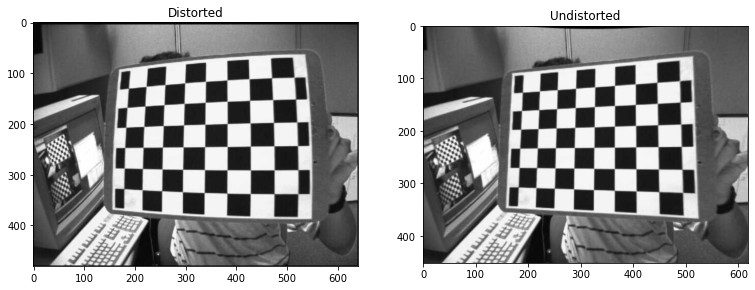

In [163]:
# Show the results
plt.figure(figsize=(12.8, 4.8))
plt.subplot(1,2,1)
plt.title("Distorted")
plt.imshow(img)
plt.subplot(1,2,2)
plt.title("Undistorted")
plt.imshow(dst)
plt.show()

As observed above, the lines in the checkerboard have become straight through the process of un-distortion. If the ROI is not applied, the shape of output and input will be the same. Since the ROI is applied, most of the dead pixels (black zeros) is not present in the undistorted image.

#### Using OpenCV built-in method

Using the function [cv.calibrateCamera](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga687a1ab946686f0d85ae0363b5af1d7b) (which is an overload of [this](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d)). A detailed description of the parameters is given in the `Zhang's Method` section. For this, the points in a plane of the **given image (circles and measurements)** are used.

The following is passed

1. `opts`: The world points. Currently, the points chosen are in a plane ($Z = 0$). The indices for these points (starting from 1) is stored in `pl_pts`.
2. `ipts`: The corresponding image coordinates of the points
3. `imshape`: The shape of the image. Directly, you could enter $(5472, 3648)$ as the shape (width, height)
4. The following two `None` values are for signifying no initial guess for camera matrix and distortion parameters

In [233]:
pl_pts = [1, 3, 20, 16, 18, 5, 12, 7, 8, 17]    # Points in a plane
pl_pts = np.array(pl_pts) - 1
# Get the correspondences
obj_pts = clicked_pts_world_mm[np.newaxis, pl_pts] # World points
img_pts = clicked_pts_img[np.newaxis, pl_pts]  # Image points
imshape = img1.shape[1::-1] # Width, Height of image
# fname = "./P_dlt6.npy"
# P_init = np.load(fname) # Restore from backup
# R, K, X_o = ret_RKT_qr(P_init)  # Decompose
# K_init = K

In [234]:
# Convert to OpenCV types
opts = obj_pts.astype(np.float32)
ipts = img_pts.astype(np.float32)
# Main function for calibration and distortion estimate
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(opts, ipts, imshape, 
    None, None)

In [235]:
print(f"Distortion parameters k1, k2, p1, p2, k3:\n {dist}")

Distortion parameters k1, k2, p1, p2, k3:
 [[-1.21042988e+00  1.71065656e+01  2.63160224e-02 -2.28270928e-02
  -6.68058062e+01]]


From the observations, the distortion parameters $k_1, k_2, p_1, p_2, k_3$ are given as

```txt
[[-1.21042988e+00  1.71065656e+01  2.63160224e-02 -2.28270928e-02 -6.68058062e+01]]
```

The tangential distortion is almost zero (in orders of `e-02`, or $10^{-2}$), so it can be ignored. The radial distortion, however, is somewhat bigger.

The equation for radial distortion is given by

$$ \mathbf{x}_{d} = \mathbf{x} (1 + k_1 r^2 + k_2 r^4 + k_3 r^6) $$
$$ \mathbf{y}_{d} = \mathbf{y} (1 + k_1 r^2 + k_2 r^4 + k_3 r^6) $$

Upon plotting the equation, it seems like it is a slight [mustache distortion](https://en.wikipedia.org/wiki/Distortion_(optics)#mustache_distortion) (because it decreases and then increases, then finally decreases).

<img src="./../images/distortion_eq.jpg" width=400/>


Save this result for future use

In [236]:
# Get the elements
K = mtx
R = Rotation.from_rotvec(rvecs[0].flatten()).as_matrix()
X_o = tvecs[0]
# K[0, 2] = imshape[0]/2  # Width /2
# K[1, 2] = imshape[1]/2  # Height/2
# K = K @ rot_z_pi / K[2,2]
# Create P
P_re = K @ R @ np.hstack((np.eye(3), -X_o.reshape(3, 1)))

In [237]:
# Save and restore
fname = "./P_zhang.npy"
# np.save(fname, P_re)
P_re = np.load(fname)

### Wireframe

The wireframe overlay of image points

Select the points that should be connected using a line (in that order)

In [192]:
wi = [3, 1, 20, 16, 5, 18, 12, 7, 8, 17, 9, 10, 11, 6, 13, 15, 14, 19, 
    2, 4]   # Point indices
i = np.array(wi) - 1
w_pts = clicked_pts_world_mm[i]

Project the world points onto the image, then check the absolute error (using the ground truth as the image pixels).

In [238]:
# Load camera projection matrix from backup
fname = "./P_dlt_ransac.npy"
P_re = np.load(fname)
# Project world points on the image
im_pts = P_re @ np.hstack((w_pts, np.ones((N, 1)))).T
im_pts = im_pts/im_pts[2]   # Homogeneous to pixel coordinates
im_pts = im_pts[:2,:].T # N, 2

In [239]:
# Absolute pixel error
ae = np.sum(np.linalg.norm(im_pts - clicked_pts_img[i], axis=1))
print(f"Absolute error of {ae:.2f} pixels")

Absolute error of 187.22 pixels


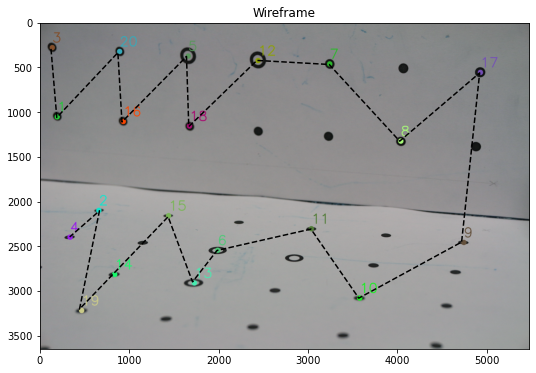

In [240]:
# Show the wireframe
img = cv.imread("./../images/clicked_pts.jpg")
plt.figure(figsize=(10, 6))
plt.title("Wireframe")
plt.imshow(img)
plt.plot(im_pts[:,0], im_pts[:,1], 'k--')
plt.show()

As seen above, the wireframe can be seen passing (approximately) through the points (in the mentioned order). It is shown again below

<img src="./../images/wireframe.png" style="background-color:white" width=450 />

#### Wireframe for Zhang's

For the wireframe using Zhang's method (described below), the camera projection matrix is loaded from the saved file (saved in the distortion example above).

Load the camera projection matrix

In [241]:
# Load from backup
fname = "./P_zhang.npy"
P_re = np.load(fname)

In [246]:
# Project world points on the image
im_pts = P_re @ np.hstack((w_pts, np.ones((N, 1)))).T
im_pts = im_pts/im_pts[2]   # Homogeneous to pixel coordinates
im_pts = im_pts[:2,:].T # N, 2
# Absolute pixel error
ae = np.sum(np.linalg.norm(im_pts - clicked_pts_img[i], axis=1))
print(f"Absolute error of {ae:.2f} pixels")

Absolute error of 87156.31 pixels


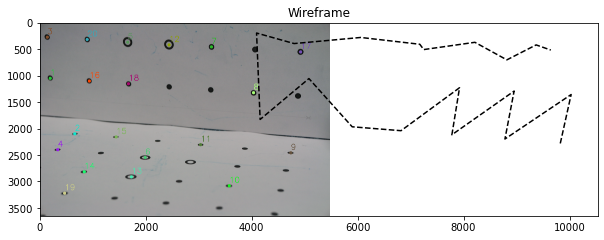

In [244]:
# Show the wireframe
img = cv.imread("./../images/clicked_pts.jpg")
plt.figure(figsize=(10, 6))
plt.title("Wireframe")
plt.imshow(img)
plt.plot(im_pts[:,0], im_pts[:,1], 'k--')
plt.show()

This did not work. This is probably because the points chosen for calibration were on the same plane. This means that the intrinsics were proper, but the extrinsic parameters of the camera could be wrong. Let us use the extrinsic of the RANSAC method and the intrinsic through Zhang's

In [249]:
# Load the RANSAC result
fname = "./P_dlt_ransac.npy"
P_re = np.load(fname)
# Decompose into R, K, X_o
R, K, X_o = ret_RKT_qr(P_re)
R_ransac, Xo_ransac = R, X_o
# Load the Zhang result
fname = "./P_zhang.npy"
P_re = np.load(fname)
# Decompose into R, K, X_o
R, K, X_o = ret_RKT_qr(P_re)
K_zhang = K
# Recreate the P matrix
R, K, X_o = R_ransac, K_zhang, Xo_ransac
R = np.diag([-1, -1, 1]) @ R
P_re = K @ R @ np.hstack((np.eye(3), -X_o.reshape(3, 1)))

In [250]:
# Project world points on the image
im_pts = P_re @ np.hstack((w_pts, np.ones((N, 1)))).T
im_pts = im_pts/im_pts[2]   # Homogeneous to pixel coordinates
im_pts = im_pts[:2,:].T # N, 2
# Absolute pixel error
ae = np.sum(np.linalg.norm(im_pts - clicked_pts_img[i], axis=1))
print(f"Absolute error of {ae:.2f} pixels")

Absolute error of 2596.12 pixels


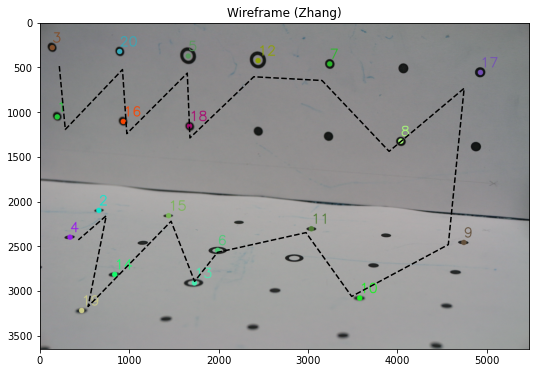

In [252]:
# Show the wireframe
img = cv.imread("./../images/clicked_pts.jpg")
plt.figure(figsize=(10, 6))
plt.title("Wireframe (Zhang)")
plt.imshow(img)
plt.plot(im_pts[:,0], im_pts[:,1], 'k--')
plt.show()

This is a more acceptable result. The extrinsics may need to be taken from RANSAC, as that calibration included points from the 3D world.

In [60]:
# Some space for rough work

---

## Zhang's Method

Calibration using Zhang's checkerboard method


Zhang's method introduced in [Z. Zhang (2000) - A flexible new technique for camera calibration](https://doi.org/10.1109/34.888718) involves using a sequence of images of a checkerboard to calibrate a camera (estimate the camera projection matrix).

Set the variables below before proceeding

1. `zhangs_chb_imgs`: Folder containing the images. Must be regex like, searchable through [glob](https://docs.python.org/3/library/glob.html#module-glob)
2. `cb_nrows`, `cb_ncols`: Number of rows and columns (inner intersections) in the checkerboard pattern.
3. `criteria`: Termination criteria as used by OpenCV. C++ description [here](https://docs.opencv.org/4.x/d9/d5d/classcv_1_1TermCriteria.html#a56fecdc291ccaba8aad27d67ccf72c57)

    Get a list of them using

    ```py
    c = [i for i in dir(cv) if 'TERM_CRITERIA' in i]
    print(c)
    ```

4. `wait_nopress`: Wait duration per image (for inspection of corners)

In [217]:
# Configurations
zhangs_chb_imgs = "./../data/checkerboard-*.JPG"    # Images path
cb_nrows, cb_ncols = 6, 8   # No. of rows, columns for checkerboard
# Termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 
    30, 0.001)  # 30 iter or change less than 0.001
# Wait duration
wait_nopress = 1000 # Wait for 1000 milliseconds (or until keypress)

In [163]:
# Find all files
img_files = glob.glob(zhangs_chb_imgs)
if len(img_files) > 0:
    print(f"Found {len(img_files)} images in '{zhangs_chb_imgs}'")
else:
    print(f"ERROR: Check if path '{zhangs_chb_imgs}' has images")

Found 15 images in './../data/checkerboard-*.JPG'


In [164]:
# Object coordinates (meshgrid) -> (X, Y, Z = 0)
# Vector of (0,0,0), (1,0,0), (2,0,0) ....,(cb_nrows, cb_ncols,0)
objp = np.array(
    [a.T 
        for a in np.meshgrid(
            np.arange(cb_nrows), np.arange(cb_ncols)
        )
    ]  # Shape
    ).T.reshape(-1, 2)
objp = np.hstack((objp, np.zeros((objp.shape[0], 1))))  # Object coord
objp = objp.astype(np.float32)  # Float32 for OpenCV

Run the corner detection and visualization on all images, detect the corner points, visualize and store them. The following is for reference

1. [cv.findChessboardCorners](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga93efa9b0aa890de240ca32b11253dd4a): Finds internal corners of chessboard patterns. All images in the folder are expected to have it (`WARN`ing message is shown otherwise). The detected coordinates are approximate, and to determine their positions more accurately, the function calls cornerSubPix. We call this function again with custom convergence parameters.
2. [cv.cornerSubPix](https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga354e0d7c86d0d9da75de9b9701a9a87e): Refines corner positions using image gradients. Note that the corners taken by the function is also modified.
3. [cv.drawChessboardCorners](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga6a10b0bb120c4907e5eabbcd22319022): Draw the chessboard corners (renders on image).

In [166]:
# Store object and image points from all images
obj_pts = []    # List of X, Y, Z points in space
img_pts = []    # List of x, y points in image plane (detected)

# Window (for displaying results)
img_winname = "Checkerboard Detection Results"
cv.namedWindow(img_winname, cv.WINDOW_NORMAL)
cv.resizeWindow(img_winname, 900, 600)
# Detection for each candidate file
for i, cb_cand_fname in enumerate(img_files):
    img = cv.imread(cb_cand_fname)  # Read image
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)  # Greyscale conversion
    # Find chessboard corners
    cfound, corners = cv.findChessboardCorners(gray, 
        (cb_nrows, cb_ncols))   # Find coarse corners
    # If corners were found
    if cfound:
        # Append all world points (fixed for all images)
        obj_pts.append(objp)
        # Refine corners
        corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1),
            criteria)   # Note that `corners` is also modified
        # Image corner points (x, y pixel coordinates)
        img_pts.append(copy.deepcopy(corners))
        # Draw and display the corners
        cv.drawChessboardCorners(img, (cb_nrows, cb_ncols), corners2, 
            cfound) # Renders on 'img' (color image)
        cv.imshow(img_winname, img)
        cv.waitKey(wait_nopress)
    else:
        print(f"WARN: No corners found in file no. {i}")
# Cleanup
cv.destroyWindow(img_winname)

In [167]:
# Failsafe, in case something crashes above and the window freezes
cv.destroyAllWindows()

### Camera calibration using OpenCV

Use the function [cv.calibrateCamera](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga687a1ab946686f0d85ae0363b5af1d7b) (which is an overload of [this](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d)).

The return values have the following description

1. `ret`: The overall RMS re-projection error
2. `mtx`: The camera matrix, denoted by $\mathbf{K}$ in the above steps (prior to this one)
3. `dist`: Distortion coefficients. The five coefficients are $(k_1, \; k_2, \; p_1, \; p_2, \; k_3)$, where $k_1, \; k_2, \; k_3$ are for radial distortion and $p_1, \; p_2$ are for tangential distortion
4. `rvecs`: List of rotation vectors estimated for each pattern. Each item is of shape $3, 1$ and is in the [Rodrigues](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga61585db663d9da06b68e70cfbf6a1eac) form (exponential coordinates). This must be coupled with the translation vectors (described next)
5. `tvecs`: List of translation vectors for each pattern view. Must be coupled with the elements of `rvecs` (described above)

Passed parameters are as follows

1. `obj_pts`: List of object points (for each image). List must be 15 element long (15 images). Each element must be $48, 3$, (since $48 = 6 \times 8$, the number of corners) which gives the $X, Y, Z$ world coordinates of the corners. Since the checkerboard is on a plane, $Z = 0$ here.
2. `img_pts`: List of image points (correspondences for each image). List must be 15 elements long (for 15 images). Each element must be $48, 1, 2$ or $48, 2$ which gives the $u, v$ image coordinates of the corners. All data-types are 32-bit floats.
3. `gray.shape[::-1]`: The shape of the image, might as well write `[5472, 3648]` which is the $[width, height]$ of images (for estimate of the sizes in $\mathbf{K}$, for origin offset to the center of image).
4. The following two parameters are for no prior estimates.

In [168]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(obj_pts, img_pts, 
    gray.shape[::-1], None, None)   # size of img, None initial value

This thereby gives us all the camera parameters in `mtx` (intrinsic parameters, given by $\mathbf{K}$, which is an upper triangular matrix).


In [175]:
print(f"Camera projection matrix K:\n {mtx}")

Camera projection matrix K:
 [[1.36415093e+04 0.00000000e+00 3.31635835e+03]
 [0.00000000e+00 1.36632517e+04 1.50037365e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [174]:
print(f"Distortion coefficients k_1, k_2, p_1, p_2, k_3:\n{dist}")

Distortion coefficients k_1, k_2, p_1, p_2, k_3
[[ 9.79056842e-02  9.45877296e+00 -1.53012181e-02  2.72096279e-02
  -1.48434773e+02]]


### Comparison

This could be compared to the camera projection matrix in the RANSAC result. Since both scenes have different extrinsics (camera pose in the world), it is useless to compare it. The comparison can be made for the camera projection (intrinsic) matrix $\mathbf{K}$.

In the case of RANSAC on the dotted circles image, the camera intrinsic matrix was

```txt
K = [[ 1.20833304e+04 -9.08113208e+01  2.98478171e+03]
 [ 0.00000000e+00  1.19868598e+04  2.91148195e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
```

In the case of checkerboard images (using Zhang's calibration), the camera intrinsic matrix is

```txt
K = [[1.36415093e+04 0.00000000e+00 3.31635835e+03]
 [0.00000000e+00 1.36632517e+04 1.50037365e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
```

As observed

- There is some slight skew in the camera matrix in the dotted circles (DLT) case, whereas there is no skew in the Zhang's checkerboard images case
- The focal lengths are on similar magnitudes/order. This is true for X and Y. Moreover, for both the images, the focal length along both dimensions is similar.
- The pixel offsets for the center shift (last column) solely depends on the image size (in pixels).

---

## Theory questions

Some theory questions asked in the Assignment

### Image of world origin

**Question**

> 8. What is the image of the world origin, given the calibration matrix? Does this result bear out in your observations?


**Answer**

We can try getting the image / pixel locations of the world origin in the image. Let's use the RANSAC calibration matrix. The last column of the camera projection matrix should be the image of the world origin (in pixel homogeneous coordinates).

In [214]:
# Load from backup
fname = "./P_dlt_ransac.npy"
P_re = np.load(fname)   # Load from backup
print(f"P_re loaded: \n{P_re}")
# Get the last column
p_4 = P_re[:,3]
p_4 = p_4/p_4[2]
print(f"World origin should be: [{p_4[0]:.2f}, {p_4[1]:.2f}]")

P_re loaded: 
[[ 3.98168877e-03  3.79374658e-04  1.87264403e-03 -9.11820054e-01]
 [ 2.03621580e-04  4.29959972e-03 -7.92939937e-04 -4.10542923e-01]
 [-6.81283365e-08  1.46718681e-07  3.15800199e-07 -1.90326894e-04]]
World origin should be: [4790.81, 2157.04]


Project world origin

In [215]:
# World origin
w_pt = np.array([0, 0, 0, 1]).reshape(-1, 1)
im_wo = P_re @ w_pt
im_wo = (im_wo/im_wo[2]).flatten()
wx, wy = im_wo[0], im_wo[1]
print(f"World origin is: [{wx:.2f}, {wy:.2f}]")

World origin is: [4790.81, 2157.04]


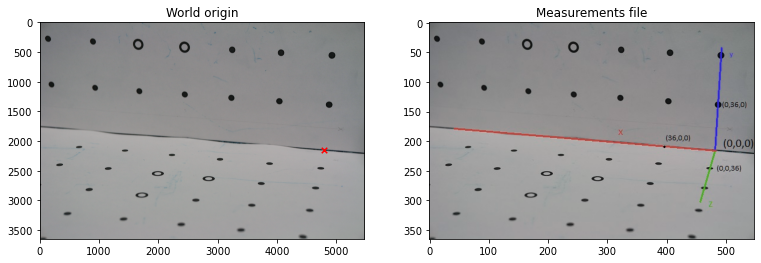

In [216]:
# Show it on image
img = cv.imread("./../data/black-dots.JPG")
img_m = cv.imread("./../data/measurements.jpg")
# Show in matplotlib
plt.figure(figsize=(12.8, 4.8))
# Actual world origin
plt.subplot(1,2,1)
plt.title("World origin")
plt.imshow(img)
plt.scatter(wx, wy, 30, c='r', marker='x')
# Measurements given
plt.subplot(1,2,2)
plt.title("Measurements file")
plt.imshow(img_m)
plt.show()

From the above, it is clear that the world origin is correctly captured by our camera projection matrix.

---

## Personal Camera

Redo calibration using the three methods (direct DLT, RANSAC-DLT, Zhang's) using a personal camera

Pick a video camera and click some image of a reference object

In [253]:
# Main camera work
webcam_id = 0
cam = cv.VideoCapture(webcam_id)
imc = 0 # Image counter
while True:
    ret, img = cam.read()
    if not ret:
        print("Camera did not give frames")
        break
    cv.imshow("Feed", img)
    key = cv.waitKey(1)
    if key == ord('q'):
        print("Quit command received")
        break
    elif key == ord('c'):
        imc += 1
        fname = f"./cam_{imc}.jpg"
        print(f"Capturing image to '{fname}'")
        cv.imwrite(fname, img)
cam.release()
cv.destroyAllWindows()

Capturing image to './cam_1.jpg'
Quit command received


The image is of a Rubik's cube, as shown below

<img src="./../images/cam_1.jpg" width=400/>

The length of one cell (each side or edge has three) is `19 mm`


Using the same point picker as before (changed the window and font parameters)

In [257]:
# A function that takes an image and returns the marked indices
def get_clicked_points(img, img_winname = "Point Picker", 
    dmesg = False):
    """
        Get the clicked locations as a list of [x, y] points on image
        given as 'img'. Note that the origin is at the top left corner
        with X to the right and Y downwards.

        Parameters:
        - img: np.ndarray   shape: N, M, C
            An image, should be handled by OpenCV or be a numpy array
            (height, width, channels). The passed image is not altered
            by the function.
        - img_winname: str  default: "Point Picker"        
            Window name (to be used by OpenCV)
        - dmesg: bool or str    default: False
            If True (or `str` type) a string for debug is printed. If
            the type is `str`, then the string is prepended to the
            debug message.

        Returns:
        - img_points: list
            A list of [x, y] points clicked on the image
        - _img: np.ndarray  shape: N, M, C
            The same image, but annotated with points clicked. Random
            colors are assigned to each point.
    """
    img_points = [] # A list of [x, y] points (clicked points)
    _img: np.ndarray = img.copy()   # Don't alter img
    # Main event handler
    def img_win_event(event, x, y, flags, params):
        if event == cv.EVENT_LBUTTONUP:
            # Print the debug message (if True or 'str')
            if dmesg == True or type(dmesg) == str:
                db_msg = f"Clicked on point (x, y): {x}, {y}"
                if type(dmesg) == str:
                    db_msg = dmesg + db_msg
                print(db_msg)
            # Record point
            img_points.append([x, y])   # Record observation
            # -- Put marker on _img for the point --
            # Random OpenCV BGR color as tuple
            _col = tuple(map(int, np.random.randint(0, 255, 3)))
            # Add circle
            cv.circle(_img, (x, y), 10, _col, -1)
            # Add text
            cv.putText(_img, f"{len(img_points)}", (x, y-15),
                cv.FONT_HERSHEY_SIMPLEX, 1, _col, 2, cv.LINE_AA)
    # Create GUI Window
    cv.namedWindow(img_winname, cv.WINDOW_NORMAL)
    cv.resizeWindow(img_winname, 640, 480)  # Window (width, height)
    cv.setMouseCallback(img_winname, img_win_event)
    # Main loop
    while True:
        cv.imshow(img_winname, _img)
        k = cv.waitKey(1)
        if k == ord('q'):
            break
    cv.destroyWindow(img_winname)
    # Return results
    return img_points, _img


Pick the world points


In [259]:
fname = "./../images/cam_1.jpg"
img = cv.imread(fname)
pts, img_tmp = get_clicked_points(img, "Picker", "\t")

	Clicked on point (x, y): 299, 250
	Clicked on point (x, y): 202, 201
	Clicked on point (x, y): 288, 162
	Clicked on point (x, y): 379, 199
	Clicked on point (x, y): 297, 354
	Clicked on point (x, y): 369, 291
	Clicked on point (x, y): 211, 302
	Clicked on point (x, y): 266, 235
	Clicked on point (x, y): 376, 234
	Clicked on point (x, y): 205, 240


The points clicked are as follows

<img src="./../images/clicked_pts_cam.jpg" width=400/>

Let the origin be the diagonally opposite corner (body diagonal) of point `1`. X axis is perpendicular to the yellow face, Y axis is perpendicular to the green face, Z axis is perpendicular to the orange face (all outwards)

In [263]:
img_pts = np.array(pts, float)
world_pts = np.array([
    [3, 3, 3],  # 1
    [3, 0, 3],  # 2
    [0, 0, 3],  # 3
    [0, 3, 3],  # 4
    [3, 3, 0],  # 5
    [0, 3, 0],  # 6
    [3, 0, 0],  # 7
    [3, 2, 3],  # 8
    [0, 3, 2],  # 9
    [3, 0, 2],  # 10
], float) * 19  # World points (all in mm)

In [268]:
# Save and load
fname = "./clicked_corres_cam.npz"
# np.savez(fname, img_pts=img_pts, world_pts=world_pts)
# Restore from backup
data = np.load(fname)
img_pts : np.ndarray = data["img_pts"]
world_pts : np.ndarray = data["world_pts"]

### Calibration using DLT

Using the 6-point DLT functions to calibrate

In [272]:
# 6 random correspondences
N, _ = img_pts.shape
i = np.random.choice(N, 6, replace=False)
X_pts = world_pts[i]
x_pts = img_pts[i]
# Get the P estimate
P = DLT_SVD_estimateP(X_pts, x_pts)
R, K, X_o = ret_RKT_qr(P)   # Decompose P
# Reconstruct it
P_re = K @ R @ np.hstack((np.eye(3), -X_o.reshape(3, 1)))
if np.allclose(P/P[2, 3], P_re/P_re[2, 3]):
    print("Reconstruction verified")

Reconstruction verified


In [273]:
# Save and restore
fname = "./P_cam_dlt6.npy"
# np.save(fname, P)
P_re = np.load(fname)   # Load from backup
R, K, X_o = ret_RKT_qr(P_re)   # Decompose P_re
print(f"K = {K}\nR = {R}\nX_o (in mm) = {X_o}")

K = [[ 3.47965208e-09 -1.22810236e-10  2.66000000e+02]
 [ 0.00000000e+00  2.58315165e-09  2.35000000e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
R = [[ 7.06426941e-01 -7.06426941e-01  4.38401100e-02]
 [-3.09996390e-02  3.09996390e-02  9.99038560e-01]
 [-7.07106781e-01 -7.07106781e-01  3.33562347e-12]]
X_o (in mm) = [39.10107422 17.89941406 38.22949219]


It seems like this is correct

In [275]:
# Get reprojected points
x_im = P_re @ np.hstack((world_pts, np.ones((N, 1)))).T
x_im = x_im/x_im[2]
# Error vector
err = x_im - np.vstack((img_pts.T, np.ones((1, N))))
deviation = np.linalg.norm(err, axis=0) # Pixel deviation per point
td = np.sum(deviation)  # Total deviation
print(f"Total deviation of {td:.3f} pixels")

Total deviation of 256.150 pixels


### Calibration using RANSAC

Using RANSAC for calibration

In [276]:
P_best, ncpts, p_vals = RANSAC_DLT_sampling(world_pts, img_pts, 5, 
    0.99, 0.30)
P_best = p_vals[np.argmax(ncpts)]
# Decompose the best P value
R, K, X_o = ret_RKT_qr(P_best)
# Reconstruct P
P_re = K @ R @ np.hstack((np.eye(3), -X_o.reshape(3, 1)))
if np.allclose(P_best/P_best[2, 3], P_re/P_re[2, 3]):
    print("Reconstruction verified")

Reconstruction verified


In [277]:
# Save and restore
fname = "./P_cam_dlt_ransac.npy"
# np.save(fname, P_best)
P_re = np.load(fname)   # Load from backup
R, K, X_o = ret_RKT_qr(P_re)   # Decompose P_re
print(f"K = {K}\nR = {R}\nX_o (in mm) = {X_o}")

K = [[ 533.89648026   10.17446454  382.93109189]
 [  -0.         -530.34014034  207.20146115]
 [  -0.           -0.            1.        ]]
R = [[ 0.54137361 -0.83651582 -0.08459258]
 [ 0.38649783  0.33695173 -0.85853536]
 [ 0.74668202  0.43209353  0.50572832]]
X_o (in mm) = [191.69732686 170.5136689  183.2582653 ]


In [278]:
# Get reprojected points
x_im = P_re @ np.hstack((world_pts, np.ones((N, 1)))).T
x_im = x_im/x_im[2]
# Error vector
err = x_im - np.vstack((img_pts.T, np.ones((1, N))))
deviation = np.linalg.norm(err, axis=0) # Pixel deviation per point
td = np.sum(deviation)  # Total deviation
print(f"Total deviation of {td:.3f} pixels")

Total deviation of 13.085 pixels


The RANSAC method gives _much_ better results

### Zhang's Method

Using the checkerboard from [here](https://github.com/opencv/opencv/blob/master/samples/data/chessboard.png)

Capture images using webcam

In [328]:
# Main camera work
webcam_id = 0
cam = cv.VideoCapture(webcam_id)
imc = 0 # Image counter
while True:
    ret, img = cam.read()
    if not ret:
        print("Camera did not give frames")
        break
    cv.imshow("Feed", img)
    key = cv.waitKey(1)
    if key == ord('q'):
        print("Quit command received")
        break
    elif key == ord('c'):
        imc += 1
        fname = f"./cam_cb_{imc}.jpg"
        print(f"Capturing image to '{fname}'")
        cv.imwrite(fname, img)
cam.release()
cv.destroyAllWindows()

Capturing image to './cam_cb_1.jpg'
Capturing image to './cam_cb_2.jpg'
Capturing image to './cam_cb_3.jpg'
Capturing image to './cam_cb_4.jpg'
Capturing image to './cam_cb_5.jpg'
Capturing image to './cam_cb_6.jpg'
Capturing image to './cam_cb_7.jpg'
Capturing image to './cam_cb_8.jpg'
Quit command received


Set the variables

In [329]:
# Configurations
zhangs_chb_imgs = "./../data/Checkerboard/cam_cb_*.jpg"    # Glob path
cb_nrows, cb_ncols = 7, 7   # No. of rows, columns for checkerboard
# Termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 
    30, 0.001)  # 30 iter or change less than 0.001
# Wait duration
wait_nopress = 1000 # Wait for 1000 milliseconds (or until keypress)
sq_sz = 19  # Edge length of the squares

In [332]:
# Find all files
img_files = glob.glob(zhangs_chb_imgs)
if len(img_files) > 0:
    print(f"Found {len(img_files)} images in '{zhangs_chb_imgs}'")
else:
    print(f"ERROR: Check if path '{zhangs_chb_imgs}' has images")

Found 8 images in './../data/Checkerboard/cam_cb_*.jpg'


In [333]:
# Object coordinates (meshgrid) -> (X, Y, Z = 0)
# Vector of (0,0,0), (1,0,0), (2,0,0) ....,(cb_nrows, cb_ncols,0)
objp = np.array(
    [a.T 
        for a in np.meshgrid(
            np.arange(cb_nrows), np.arange(cb_ncols)
        )
    ]  # Shape
    ).T.reshape(-1, 2)
objp = np.hstack((objp, np.zeros((objp.shape[0], 1))))  # Object coord
objp = objp.astype(np.float32)  # Float32 for OpenCV
objp *= sq_sz

Main corner detection, refinement and display of checkerboard

In [334]:
# Store object and image points from all images
obj_pts = []    # List of X, Y, Z points in space
img_pts = []    # List of x, y points in image plane (detected)

# Window (for displaying results)
img_winname = "Checkerboard Detection Results"
cv.namedWindow(img_winname, cv.WINDOW_NORMAL)
cv.resizeWindow(img_winname, 640, 480)
# Detection for each candidate file
for i, cb_cand_fname in enumerate(img_files):
    img = cv.imread(cb_cand_fname)  # Read image
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)  # Greyscale conversion
    # Find chessboard corners
    cfound, corners = cv.findChessboardCorners(gray, 
        (cb_nrows, cb_ncols), None)   # Find coarse corners
    # If corners were found
    if cfound:
        # Append all world points (fixed for all images)
        obj_pts.append(objp)
        # Refine corners
        corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1),
            criteria)   # Note that `corners` is also modified
        # Image corner points (x, y pixel coordinates)
        img_pts.append(copy.deepcopy(corners))
        # Draw and display the corners
        cv.drawChessboardCorners(img, (cb_nrows, cb_ncols), corners2, 
            cfound) # Renders on 'img' (color image)
        cv.imshow(img_winname, img)
        cv.waitKey(wait_nopress)
    else:
        print(f"WARN: No corners found in file no. {i}")
# Cleanup
cv.destroyWindow(img_winname)

In [303]:
# Failsafe, in case something crashes above and the window freezes
cv.destroyAllWindows()

An example is shown below

<img src="./../data/Checkerboard/cam_cb_8.jpg" width=300>
<img src="./cb_out_8.jpg" width=300>

Calibrate the camera

In [335]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(obj_pts, img_pts, 
    gray.shape[::-1], None, None)   # size of img, None initial value

In [336]:
print(f"Camera projection matrix K:\n {mtx}")
print(f"Distortion coefficients k_1, k_2, p_1, p_2, k_3:\n{dist}")

Camera projection matrix K:
 [[518.48509884   0.         312.60137621]
 [  0.         532.50959493 224.66132009]
 [  0.           0.           1.        ]]
Distortion coefficients k_1, k_2, p_1, p_2, k_3:
[[-0.0127422  -0.21480072  0.00879695 -0.01826075  4.46438399]]


This concludes the calibration using Zhang's method

---

# End of submission